In [1]:
import numpy as np
import pandas as pd
import dill as pickle

%load_ext autoreload
%autoreload 1
%aimport CodingFeatures
%aimport CodingTransformers

## Import and initialize train/test data and reference tables

In [2]:
# get annotated protein sequences
annotated = pd.read_csv('../data/BW25113proteome_dnaseq.csv') # get full sheet
annotated = annotated.drop_duplicates('seq').dropna() # drop duplicated proteins and missing DNA_seq
annotated['DNA_seq'] = annotated['DNA_seq'].apply(lambda x: x[3:]) # trim start codons from DNA_seq
annotated['start'] = annotated['start'] + 3 # increment sequence location index

training_data = annotated.loc[:,['DNA_seq','start']] # get sequence, location index
training_data['label'] = True # label

In [3]:
from CodingFeatures import codon_lookup

codon_table, c_lookup = codon_lookup()
AA_list = codon_table['aa'].unique()[1:]

In [4]:
import random
import re

# generate negative training set
acid_bag = list(zip(codon_table.index[3:],codon_table.f_tot[3:])) # zip AAs and total frequencies
acid_bag = [[x[0]]*int(x[1]*10000) for x in acid_bag] # expand AAs by frequencies
acid_bag = [x for X in acid_bag for x in X] # flatten list
acid_bag += 3*acid_bag
# random.seed(23)
# random.shuffle(acid_bag) # pseudo-randomize
stop_bag = ['TAA','TAA','TAA','TAA','TAA','TAA','TAG','TGA','TGA','TGA']

seq_random = []
# generate randomized sequences matching annotated lengths with known whole-genome codon biases
for i,L in enumerate(annotated.length):
    random.seed(i)
    tmp = random.sample(acid_bag,L-1)+[random.choice(stop_bag)]
    seq_random.append(''.join(tmp))
# for L in annotated.length:
#     tmp = [random.choice(acid_bag) for x in range(L-1)] + [random.choice(stop_bag)]
#     seq_random.append(''.join(tmp))

In [6]:
with open('../models/negatives_v01a.pkl','wb') as f:
    pickle.dump((seq_random),f)

In [5]:
with open('../models/negatives_v01a.pkl','rb') as f:
    seq_random = pickle.load(f)

Axes(0.125,0.125;0.775x0.775)
Axes(0.125,0.125;0.775x0.775)


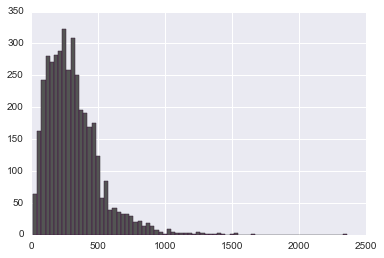

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# check length distributions
print(annotated.length.hist(bins=75, color='green'))
print(pd.Series(map(lambda x: len(x)/3,seq_random)).hist(bins=75,color='magenta',alpha=.33))

In [8]:
# reformat negative training set, label
training_random = pd.DataFrame(seq_random, columns=['DNA_seq'])
training_random['start'] = -np.arange(len(training_random))
training_random['label'] = False
# append to training_data
all_data = training_data.append(training_random, ignore_index=True)

In [9]:
from sklearn.cross_validation import train_test_split

train, test = train_test_split(all_data, train_size=.8, random_state=17)

In [10]:
from CodingFeatures import DNAAttributeConstruction, fragment_stop_delimited, fragment_windowed

train_object = DNAAttributeConstruction(list(train.DNA_seq), list(train.label), list(train.start)).decode_dna(c_lookup)
test_object = DNAAttributeConstruction(list(test.DNA_seq), list(test.label), list(test.start)).decode_dna(c_lookup)

## Feature extraction and model construction

In [11]:
from CodingFeatures import zerocross_pack, codon_bias_rms, aa_pack, class_pack, statpack1, statpack2
from CodingTransformers import ArrayFunctionTransformer
import sklearn as sk
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier as RCF
from sklearn.metrics import classification_report as clf_report

In [12]:
FU_idx = ['stp_aromatic__' + x for x in ['m','sd','p1','p2','tm','lsd','tp1','tp2']]
FU_idx += ['cpk_class__' + x for x in [z+'_'+y for z in ['polar','nonpolar','basic','acidic'] for y in ['m','sd','p1','p2','tm','lsd','tp1','tp2']]]
FU_idx += ['zcp_hydrophob__' + x for x in ['f','tm','tsd','tp1','tp2']]
FU_idx += ['stp_hydrophob__' + x for x in ['m','sd','p1','p2','tm','lsd','tp1','tp2']]
FU_idx += ['stp_codonpref__' + x for x in ['m','sd','p1','p2','tm','lsd','tp1','tp2']]
FU_idx += ['crms_frags__' + x for x in ['all','A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']]
FU_idx += ['aapk_peptides__' + x for x in [z+'_'+y for z in ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'] for y in ['f','tm','tsd','tp1','tp2']]]
print(len(FU_idx))

182


In [13]:
FU = FeatureUnion([
        ('aromatic', ArrayFunctionTransformer(statpack1,'aa_aromatic')),
        ('classes', ArrayFunctionTransformer(class_pack, 'aa_class')),
        ('hydro_z', ArrayFunctionTransformer(zerocross_pack, 'aa_hydrophob')),
        ('hydro_s', ArrayFunctionTransformer(statpack1, 'aa_hydrophob')),
        ('c_prefs', ArrayFunctionTransformer(statpack1, 'codon_pref')),
        ('c_bias', ArrayFunctionTransformer(codon_bias_rms, 'fragments', params=(c_lookup, AA_list))),
        ('aa_pack', ArrayFunctionTransformer(aa_pack, 'peptides', params=(AA_list,)))
    ], n_jobs=-1)

In [14]:
train_features = FU.transform(train_object)
test_features = FU.transform(test_object)

In [15]:
with open('../models/features_v01a.pkl','wb') as f:
    pickle.dump((train_features, test_features),f)
    
with open('../models/FU_v01a.pkl','wb') as f:
    pickle.dump(FU,f)

In [38]:
with open('../models/features_v01a.pkl','rb') as f:
    train_features, test_features = pickle.load(f)

with open('../models/FU_v01a.pkl','rb') as f:
    FU = pickle.load(f)

In [16]:
# model = RCF(random_state=17,n_jobs=-1).fit(train_features, train_object.labels)
model = RCF(random_state=17,n_jobs=-1,class_weight='balanced',n_estimators=400).fit(train_features, train_object.labels)

In [17]:
with open('../models/RFCmodel_v01a.pkl','wb') as f:
    pickle.dump(model,f)

In [47]:
with open('../models/RFCmodel_v01a.pkl','rb') as f:
    model = pickle.load(f)

In [18]:
# print(model.score(test_object, test_object.labels))
print(clf_report(test_object.labels, model.predict(test_features), digits=3))

             precision    recall  f1-score   support

      False      0.709     0.794     0.749     11658
       True      0.759     0.666     0.710     11383

avg / total      0.734     0.731     0.730     23041



In [19]:
results = pd.DataFrame(test_object.frag_index, columns=['idg', 'idn'])
results['predict'] = model.predict(test_features)
# results['predict'] = [random.choice([True,False]) for x in range(len(results))]

/Users/pmclean/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/pmclean/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


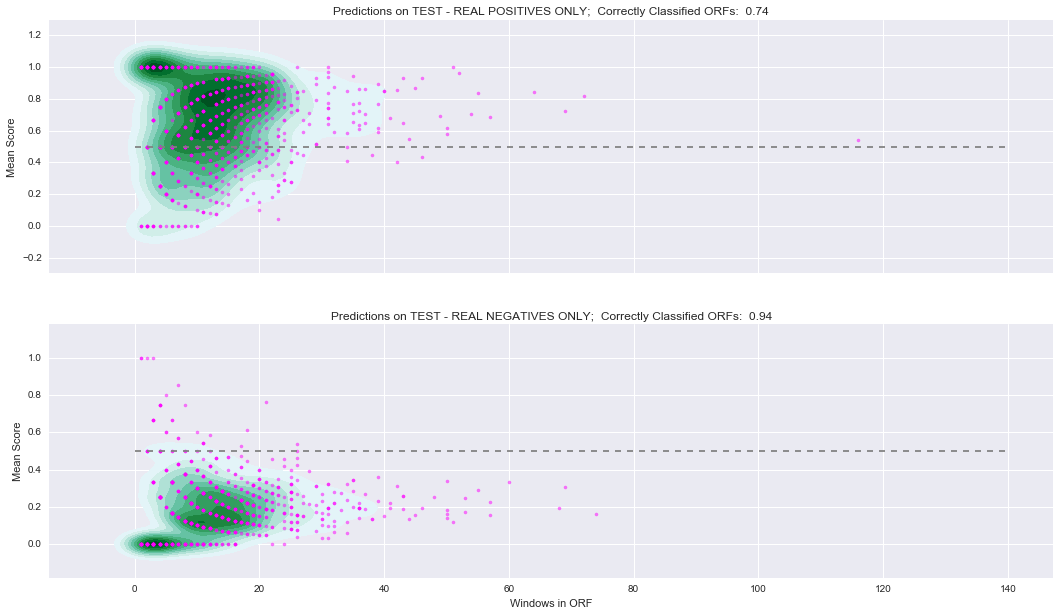

In [20]:
summary = pd.DataFrame()
summary['avg'] = results.predict.groupby(results.idg).mean()
summary['n'] = results.predict.groupby(results.idg).count()

stat0 = summary[summary.index > 0][summary.avg >= .5].avg.count()/summary[summary.index > 0].shape[0]
stat1 = summary[summary.index <= 0][summary.avg < .5].avg.count()/summary[summary.index <= 0].shape[0]

# ax = summary.tail(-1).plot(kind='scatter', x='n', y='avg', )
fig,ax = plt.subplots(nrows=2,figsize=(18,10),sharex=True)
ax[0].set_title('Predictions on TEST - REAL POSITIVES ONLY;  Correctly Classified ORFs:  {0:.{1}f}'.format(stat0,2))
ax[1].set_title('Predictions on TEST - REAL NEGATIVES ONLY;  Correctly Classified ORFs:  {0:.{1}f}'.format(stat1,2))
ax[1].set_xlabel('Windows in ORF')
ax[0].set_ylabel('Mean Score')
ax[1].set_ylabel('Mean Score')
ax[0].hlines(.5,0,140,linestyles='dashed', color='grey')
ax[1].hlines(.5,0,140,linestyles='dashed', color='grey')
sns.kdeplot(summary[summary.index > 0][['n','avg']], shade=True, shade_lowest=False, ax=ax[0])
sns.kdeplot(summary[summary.index <= 0][['n','avg']], shade=True, shade_lowest=False, ax=ax[1])
ax[0].scatter(summary[summary.index > 0].n, summary[summary.index > 0].avg, color='magenta', alpha=.5, s=10)
ax[1].scatter(summary[summary.index <= 0].n, summary[summary.index <= 0].avg, color='magenta', alpha=.5, s=10)

In [21]:
feature_weights_ = sorted(zip(model.feature_importances_, FU_idx), reverse=True)
print(feature_weights_[:20])
print()
print(feature_weights_[-20:])
print()
for x in feature_weights_:
    print(round(x[0],3), x[1])

[(0.03966753064521239, 'stp_codonpref__m'), (0.023857321470511693, 'stp_hydrophob__m'), (0.02258895758277223, 'stp_codonpref__p1'), (0.014872219414999414, 'crms_frags__I'), (0.014802420808861011, 'crms_frags__R'), (0.014208342066806516, 'crms_frags__L'), (0.013878823528096312, 'crms_frags__all'), (0.012999357465997247, 'zcp_hydrophob__tsd'), (0.01248124099200318, 'cpk_class__nonpolar_tm'), (0.010549434089617225, 'stp_codonpref__sd'), (0.0095861963420146041, 'cpk_class__polar_tm'), (0.0090549042897974125, 'cpk_class__acidic_tp2'), (0.009004777524648018, 'stp_codonpref__lsd'), (0.0089961261926493532, 'cpk_class__acidic_sd'), (0.0089934898438172525, 'cpk_class__acidic_tm'), (0.0089592685920032548, 'crms_frags__S'), (0.0089134898072776043, 'cpk_class__acidic_p2'), (0.0088989915344213702, 'cpk_class__acidic_lsd'), (0.0087886585859073482, 'stp_codonpref__tp2'), (0.0087703005764106709, 'stp_hydrophob__sd')]

[(0.00099528521069806104, 'crms_frags__Y'), (0.00095226928052760034, 'aapk_peptides__

In [22]:
# names for all genes that scored 0 or 1 for all windows
cases_0 = list(annotated[annotated.start.isin(summary[summary.avg==0].index)].short)
print('FULLY MISSED')
for x in cases_0:
    print(x)
print('FULLY FLAGGED')
cases_1 = list(annotated[annotated.start.isin(summary[summary.avg==1].index)].short)
for x in cases_1:
    print(x)

FULLY MISSED
 RNA polymerase, sigma 19 factor 
 response regulator inhibitor for tor operon 
 transcriptional activator of asnA; autorepressor 
 toxic polypeptide, small 
 hydrogenase 2 accessory protein 
 GDP-mannose mannosyl hydrolase 
 antitoxin of the SohA(PrlF)-YhaV toxin-antitoxin system 
 uncharacterized protein 
 acyl-CoA esterase 
 flavin reductase like-protein 
 UPF0125 family protein 
 CP4-57 prophage; uncharacterized protein 
 putative NAD(P)-dependent oxidoreductase with NAD(P)-binding Rossmann-f
 UPF0235 family protein 
 DUF2623 family protein 
 membrane protein insertion efficiency factor, inner membrane protein, U
 putative 4Fe-4S mono-cluster protein 
 bioflm peroxide resistance protein 
 toxin of the YoeB-YefM toxin-antitoxin system 
 putative periplasmic pilin chaperone 
 putative nucleoside-diphosphate-sugar epimerase 
 tRNA(ANN) t(6)A37 threonylcarbamoyladenosine modification protein, thre
 DUF1107 family protein 
 putative Rz1-like lipoprotein, Qin prophage 
 phos

In [23]:
# random sequences that scored TRUE in all windows
# blastable sequences
for i,x in enumerate(training_data[training_data.start.isin(summary[(summary.index<=0) & (summary.avg==1)].index)].DNA_seq):
    print('>a%s'%i)
    print(x)

In [24]:
df_features = pd.DataFrame(test_features,columns=FU_idx)
df_features['label'] = test_object.labels
df_features['predict'] = model.predict(test_features)
# print(df_features.head())

In [25]:
tot = len(df_features.columns)-2
layout = (int(np.ceil(tot/8)),8)
print(layout)

(23, 8)


/Users/pmclean/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


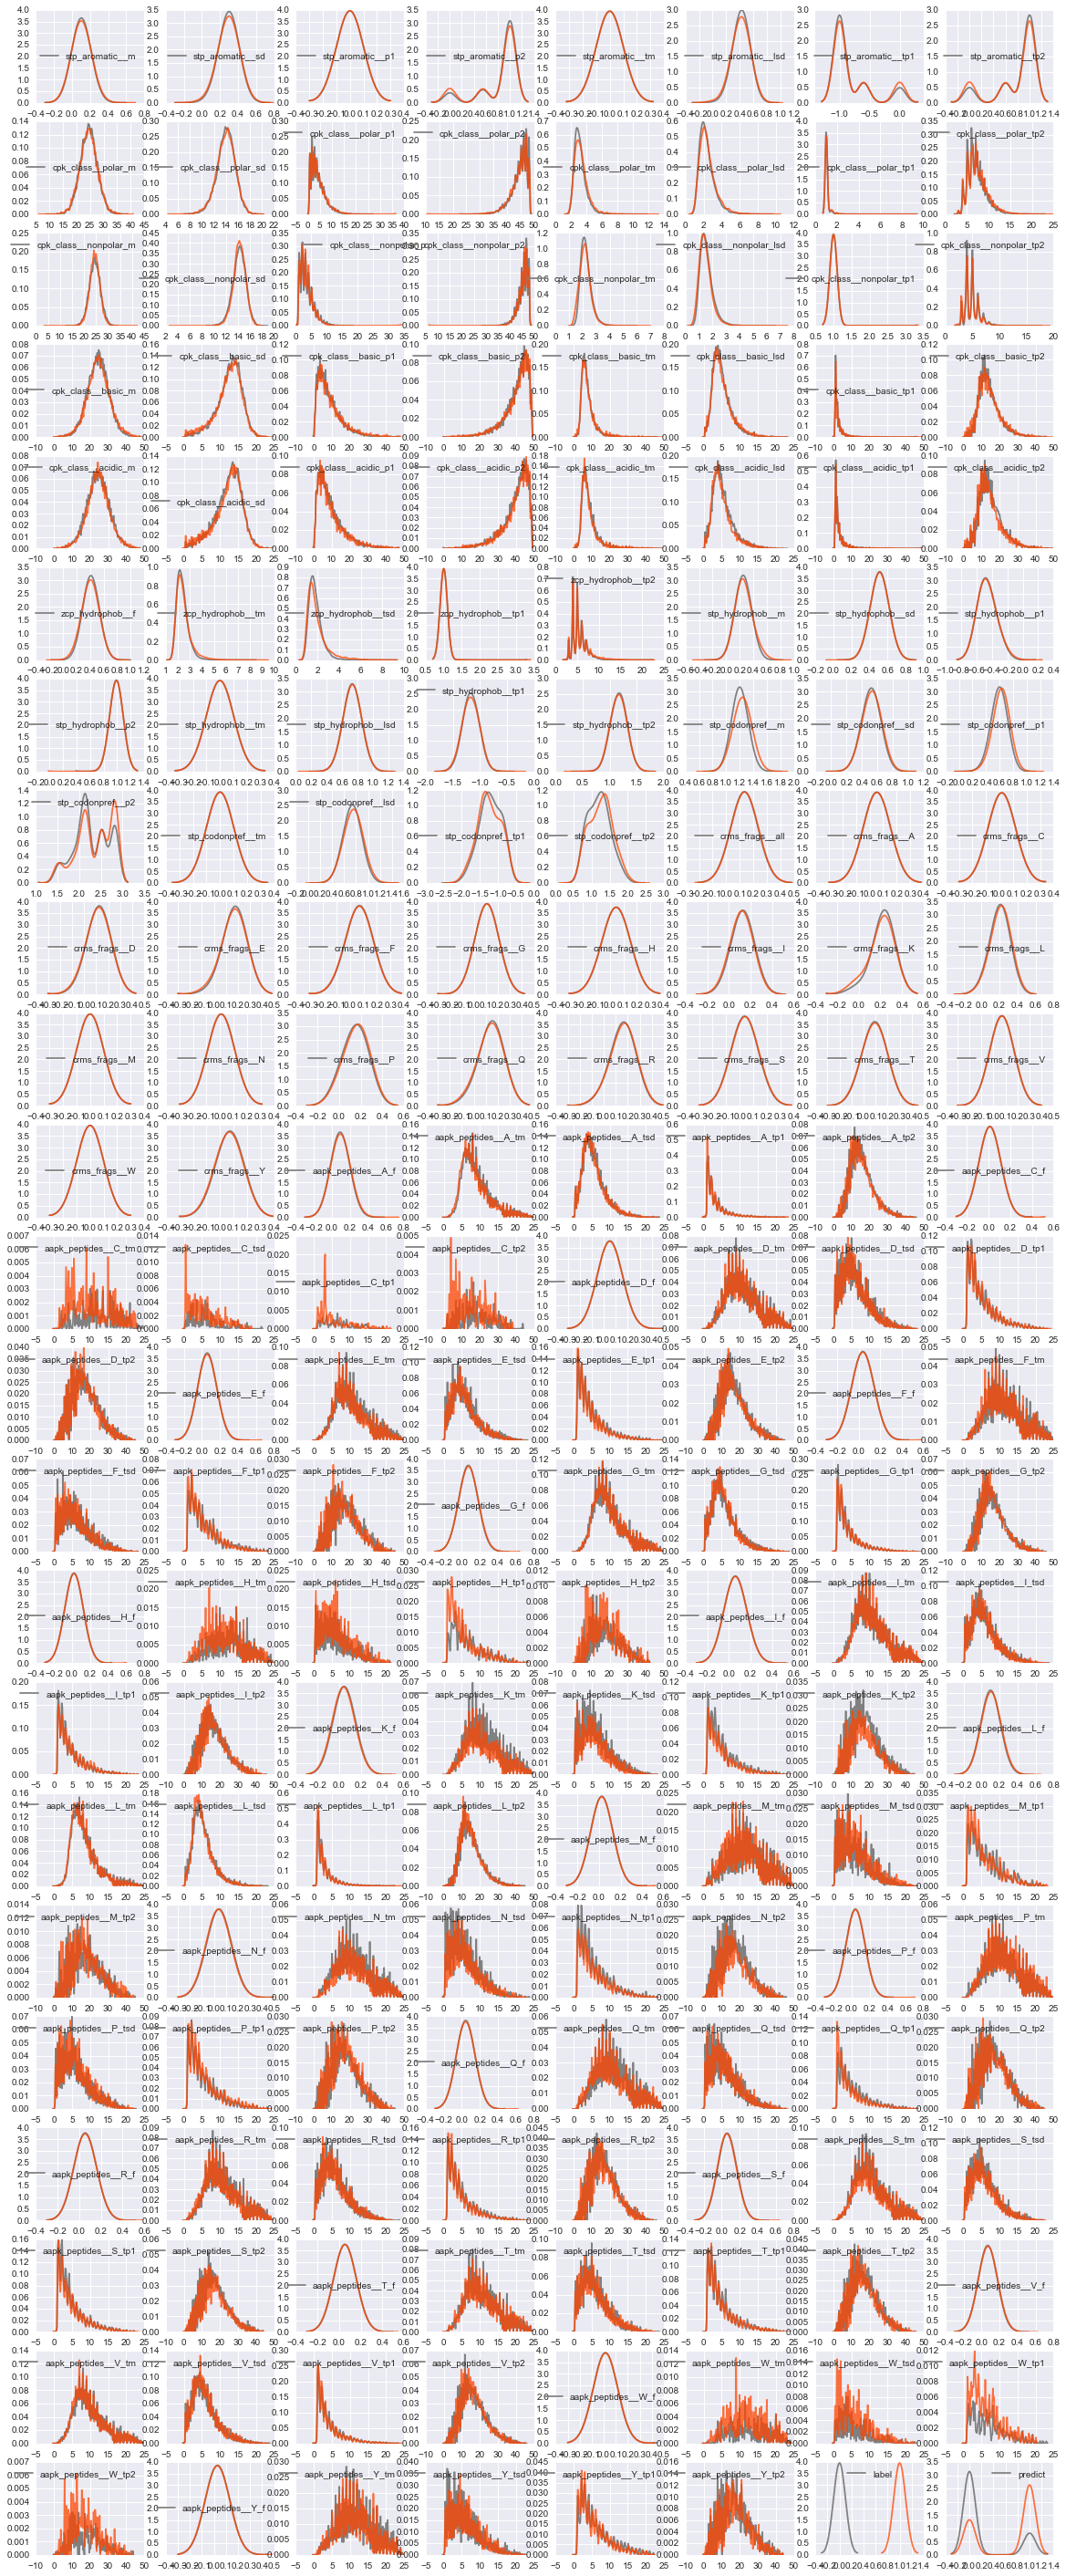

In [26]:
# layout = (int(np.ceil(91/8)),8)
fig,ax = plt.subplots(*layout,figsize=(20,50))

for i,x in enumerate(df_features.ix[:,:]):
    sns.kdeplot(df_features.ix[~df_features.label,x],bw=.1,ax=ax.flat[i],color='grey')
    sns.kdeplot(df_features.ix[df_features.label,x],bw=.1,ax=ax.flat[i],color='orangered',legend=False,alpha=.75)

plt.show()

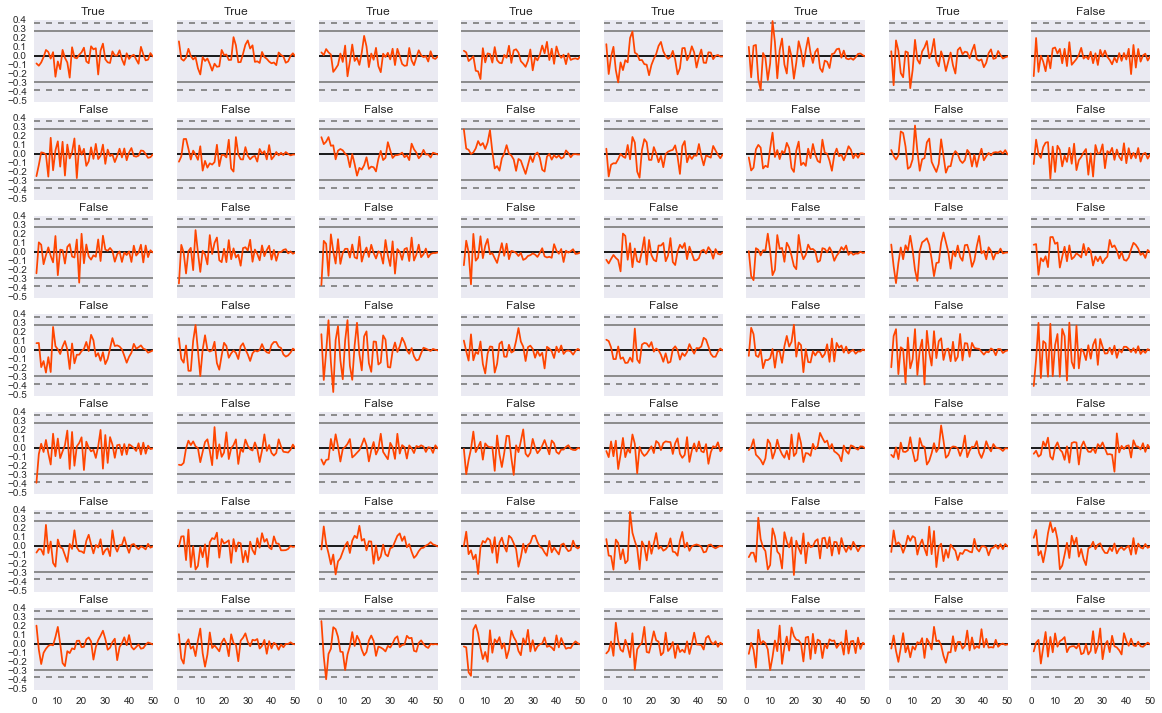

In [27]:
from pandas.tools.plotting import autocorrelation_plot

n = 56
layout = (int(np.ceil(n/8)),8)

df_auto = pd.DataFrame(test_object.aa_hydrophob[:n]).T

fig,ax = plt.subplots(*layout,figsize=(20,12),sharex=True,sharey=True)
for i,x in enumerate(df_auto):
    autocorrelation_plot(df_auto.ix[:,x], ax=ax.flat[i], color='orangered')
    ax.flat[i].set_title(test_object.labels[i])
    ax.flat[i].set_xlabel('')
    ax.flat[i].set_ylabel('')

/Users/pmclean/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


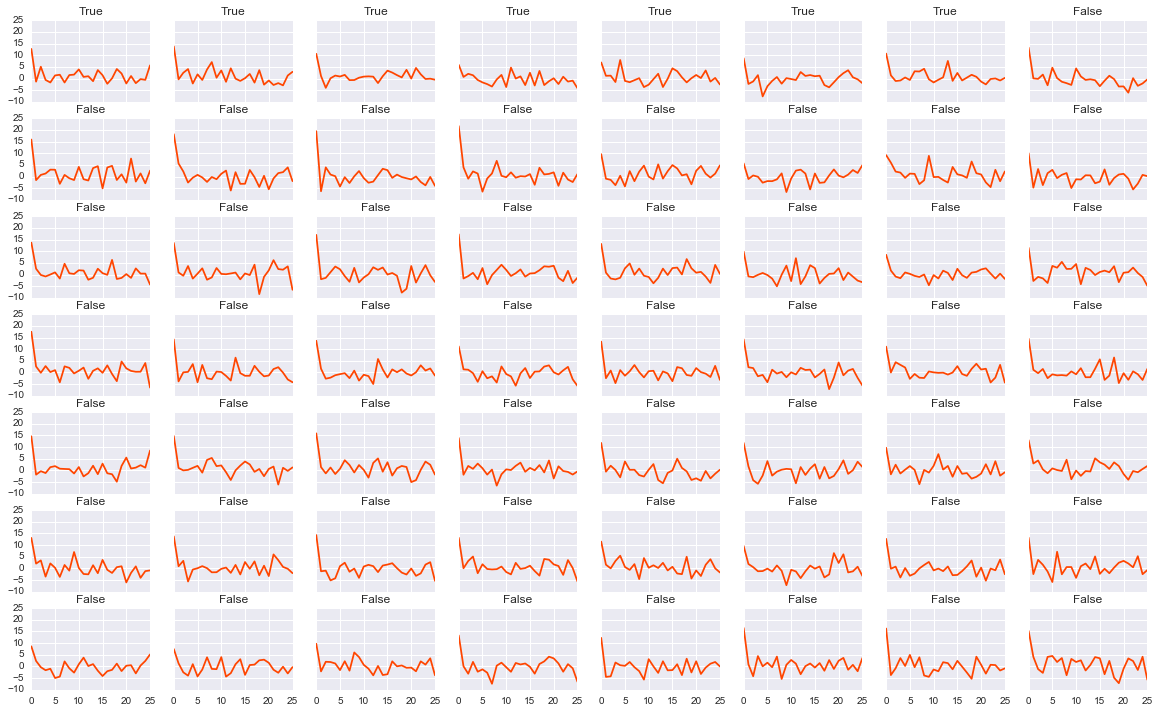

In [28]:
from scipy.fftpack import fft

n = 56
layout = (int(np.ceil(n/8)),8)

df_fft = pd.DataFrame(test_object.aa_hydrophob[:n]).T.apply(lambda x: fft(x))
L = int(df_fft.shape[0]/2)

fig,ax = plt.subplots(*layout,figsize=(20,12),sharex=True,sharey=True)
for i,x in enumerate(df_fft):
    ax.flat[i].plot(df_fft.ix[0:L,x],color='orangered')
    ax.flat[i].set_title(test_object.labels[i])
    ax.flat[i].set_xlabel('')
    ax.flat[i].set_ylabel('')